# Kaplan-Meier Estimator

The Kaplan-Meier estimator is a non-parametric estimator of the survival function of lifetime data that can be used even in the presence of right-censoring.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)

from survive.univariate import KaplanMeier
from survive.data import load_leukemia, load_channing

## Example 1. Leukemia Remission Times

These data are the times of remission (in weeks) of leukemia patients in a control group (group 0) and in a treatment group (group 1), taken from Table 1.1 of Cox and Oakes (1984).
Due to the presence of right-censoring in the treatment group, each observation has a censoring indicator (the `Event` column), where 0 indicates right-censoring (i.e., the patent dropping out of the study) and 1 indicates a true event (i.e., remission).

In [2]:
leukemia = load_leukemia()

### Kaplan-Meier estimator for the control group

In [3]:
km_control = KaplanMeier().fit(leukemia.Time[leukemia.Group == 0])
print(km_control.summary)

Kaplan-Meier estimator
KaplanMeier(conf_type='log-log', conf_level=0.95)

21 observations (21 failures, 0 censored)

Time  At Risk  Fail  Censor  Survival  Std. Err.  95% C.I. L  95% C.I. R
   1       21     2       0  0.904762   0.064056    0.670046    0.975294
   2       19     2       0  0.809524   0.085689    0.568905    0.923889
   3       17     1       0  0.761905   0.092943    0.519391    0.893257
   4       16     2       0  0.666667   0.102869    0.425350    0.825044
   5       14     2       0  0.571429   0.107990    0.337977    0.749241
   8       12     4       0  0.380952   0.105971    0.183067    0.577789
  11        8     2       0  0.285714   0.098581    0.116561    0.481820
  12        6     2       0  0.190476   0.085689    0.059482    0.377435
  15        4     1       0  0.142857   0.076360    0.035657    0.321162
  17        3     1       0  0.095238   0.064056    0.016259    0.261250
  22        2     1       0  0.047619   0.046471    0.003324    0.197045
  23   

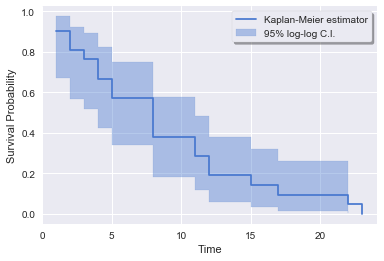

In [4]:
plt.figure()
km_control.plot()
plt.show()
plt.close()

### Kaplan-Meier estimator for the treatment group

In [5]:
time = leukemia.Time[leukemia.Group == 1]
event = leukemia.Event[leukemia.Group == 1]
km_treatment = KaplanMeier()
km_treatment.fit(time, event)
print(km_treatment.summary)

Kaplan-Meier estimator
KaplanMeier(conf_type='log-log', conf_level=0.95)

21 observations (9 failures, 12 censored)

Time  At Risk  Fail  Censor  Survival  Std. Err.  95% C.I. L  95% C.I. R
   6       21     3       1  0.857143   0.076360    0.619718    0.951552
   7       17     1       0  0.806723   0.086935    0.563147    0.922809
   9       16     0       1  0.806723   0.086935    0.563147    0.922809
  10       15     1       1  0.752941   0.096350    0.503200    0.889362
  11       13     0       1  0.752941   0.096350    0.503200    0.889362
  13       12     1       0  0.690196   0.106815    0.431610    0.849066
  16       11     1       0  0.627451   0.114054    0.367511    0.804912
  17       10     0       1  0.627451   0.114054    0.367511    0.804912
  19        9     0       1  0.627451   0.114054    0.367511    0.804912
  20        8     0       1  0.627451   0.114054    0.367511    0.804912
  22        7     1       0  0.537815   0.128234    0.267779    0.746791
  23   

Censored times are indicated by markers on the curve.

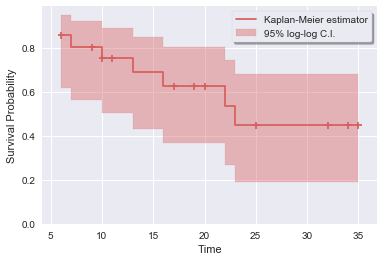

In [6]:
plt.figure()
km_treatment.plot(color="r")
plt.show()
plt.close()

### Combined Kaplan-Meier plots

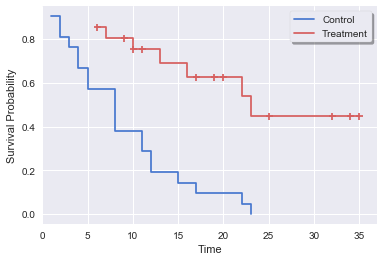

In [7]:
plt.figure()
km_control.plot(ci=False, label="Control", color="b")
km_treatment.plot(ci=False, label="Treatment", color="r")
plt.show()
plt.close()

## Example 2. Channing House Data

This is the `channing` dataset in the R package [`boot`](https://cran.r-project.org/web/packages/boot/index.html).
From the package description:
>Channing House is a retirement centre in Palo Alto, California.
>These data were collected between the opening of the house in 1964 until July 1, 1975.
>In that time 97 men and 365 women passed through the centre.
>For each of these, their age on entry and also on leaving or death was recorded.
>A large number of the observations were censored mainly due to the resident being alive on July 1, 1975 when the data was collected.
>Over the time of the study 130 women and 46 men died at Channing House.
>Differences between the survival of the sexes, taking age into account, was one of the primary concerns of this study.

In [8]:
channing = load_channing()

### Kaplan-Meier estimator for the male residents

In [9]:
km_male = KaplanMeier()
km_male.fit(channing.Exit[channing.Sex == "Male"], channing.Event[channing.Sex == "Male"])

KaplanMeier(conf_type='log-log', conf_level=0.95)

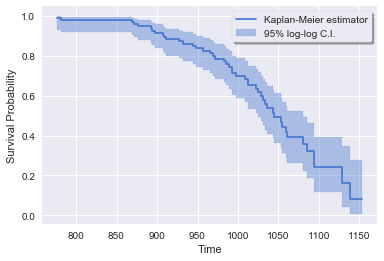

In [10]:
plt.figure()
km_male.plot(marker=None)
plt.show()
plt.close()

### Kaplan-Meier estimator for the female residents

In [11]:
km_female = KaplanMeier()
km_female.fit(channing.Exit[channing.Sex == "Female"], channing.Event[channing.Sex == "Female"])

KaplanMeier(conf_type='log-log', conf_level=0.95)

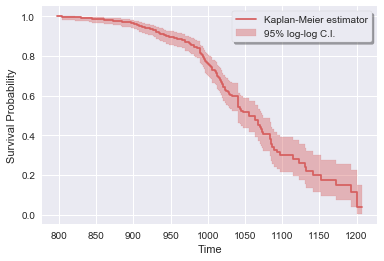

In [12]:
plt.figure()
km_female.plot(marker=None, color="r")
plt.show()
plt.close()

### Combined Kaplan-Meier plots

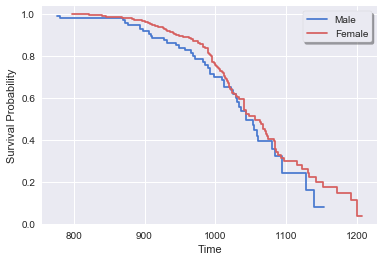

In [13]:
plt.figure()
km_male.plot(label="Male", color="b", marker=None, ci=False)
km_female.plot(label="Female", color="r", marker=None, ci=False)
plt.show()
plt.close()

## Example 3. Simulated Gamma Data with Uniform Censoring

In [14]:
rs = np.random.RandomState(0)
dist = st.gamma(a=3, scale=1)

# True failure times
true = dist.rvs(size=50, random_state=rs)

# Random censoring times
censor = st.uniform.rvs(loc=0, scale=5, size=len(true), random_state=rs)

# Observed times
observed = np.minimum(true, censor)

# Failure indicator (0=censor, 1=failure)
failure = observed == true

print(f"Proportion of censored data: {1 - np.mean(failure):.1%}")

Proportion of censored data: 46.0%


In [15]:
km = KaplanMeier(conf_type="normal")
km.fit(time=observed, event=failure)

KaplanMeier(conf_type='normal', conf_level=0.95)

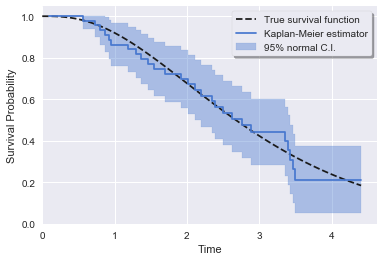

In [16]:
plt.figure()
x = np.linspace(0, max(observed), num=100)
y = 1 - dist.cdf(x)
plt.plot(x, y, ls="--", c="k", label="True survival function")
km.plot(marker=None)
plt.show()
plt.close()

## References

* E. L. Kaplan and P. Meier.
  "Nonparametric estimation from incomplete observations".
  Journal of the American Statistical Association, Volume 53, Issue 282 (1958), pp. 457--481.
  ([DOI](https://doi.org/10.2307/2281868))
* D. R. Cox and D. Oakes.
  Analysis of Survival Data.
  Chapman & Hall, London (1984), pp. ix+201.